##### INF8460 – Traitement automatique de la langue naturelle - Automne 2024

## TP3: Génération automatique de mots-clés (concepts) avec une architecture Transformer


## Identification de l'équipe:

### Groupe de laboratoire:

### Equipe numéro :

### Membres:

- membre 1 (% de contribution, nature de la contribution)
- membre 2 (% de contribution, nature de la contribution)
- membre 3 (% de contribution, nature de la contribution)

* nature de la contribution: Décrivez brièvement ce qui a été fait par chaque membre de l’équipe. Tous les membres sont censés contribuer au développement. Bien que chaque membre puisse effectuer différentes tâches, vous devez vous efforcer d’obtenir une répartition égale du travail. Soyez précis ! N'indiquez pas seulement : travail réparti équitablement

## 1. Objectif du TP

Dans ce TP, vous allez devoir implémenter en `PyTorch` un modèle suivant l'architecture Transformer créée initialement dans l'article "[Attention Is All You Need](https://arxiv.org/pdf/1706.03762)".
<br>
Votre tâche sera d'implémenter l'architecture du Transformer et d'entraîner un modèle de type Transformer à générer les concepts clés d'une phrase. Votre modèle prendra donc en entrée une phrase quelconque en anglais et produira en sortie une séquence de mots correspondant aux concepts les plus importants de la phrase. Par exemple :
<br>

**Entrée** : "The dog jumped over the fence." <br>
**Sortie attendue** : ['dog' 'jump' 'fence']

Cette tâche a d'ailleurs plusieurs applications dans le monde réel allant de la génération de résumés jusqu'à la création de bases de connaissances à partir d'un texte.


#### Requis et ressources utiles

Il est fortement conseillé de s'être familiarisé avec la librairie `PyTorch` avant d'entamer le TP. Par exemple, vous devriez savoir comment fonctionne un objet de type `nn.Module` et ce que la fonction `forward` de cet objet fait. Plusieurs tutoriels sont disponibles sur internet expliquant clairement le fonctionnement de la librairie. Voici certaines ressources qui peuvent être utiles :
- [Build The Neural Network](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html)
- [PyTorch Tutorial](https://github.com/yunjey/pytorch-tutorial?tab=readme-ov-file)


## 2. Jeu de données

Le jeu de données est composé de paires (phrase, concepts) où une phrase est mentionnée et la liste des concepts les plus importants de la phrase est indiquée. Le jeu de données est divisé en ensembles d'entraînement, de validation et de test :
- Entraînement : 4500 examples (train.csv)
- Validation : 500 examples (val.csv)
- Test : 500 examples (test.csv)

Pour une même séquence de concepts, il y a 3 phrases pouvant être associées à ces concepts. Par exemple, pour les concepts : ['cat' 'laptop' 'lie'], les phrases suivantes y sont associées :
- A cat lying on a laptop
- A large cat lies down next to a laptop.
- There is a cat lying on top of the laptop.


## 3. LIBRAIRIES PERMISES
- Jupyter notebook
- PyTorch
- nltk
- transformers
- pandas
- matplotlib
- numpy
- Huggingface


Pour toute autre librairie, demandez à votre chargé de laboratoire

## 4. INFRASTRUCTURE

- Vous avez accès aux GPU du local L-4818. Dans ce cas, vous devez utiliser le dossier temp (voir le tutoriel VirtualEnv.pdf)

## 5. ÉTAPES DU TP

In [15]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as O
from torch.utils.data import DataLoader

# ML
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import math
import numpy as np

# System
from dataclasses import dataclass
import time
import re

# Huggingface
from tokenizers import CharBPETokenizer

Il vous faudra peut-être télécharger ce module de `nltk`

In [24]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mathi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### 1. Charger les données (2 points)

La première étape va être de charger les données des fichiers d'entraînement et d'évaluation. Pour cela, nous allons utiliser la classe `Dataset` de `PyTorch`. Complétez les fonctions de cette classe.

In [25]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, file_path: str = None, data: pd.DataFrame = None):

        if file_path is None and data is None:
            raise Exception('A file path or a dataframe must be passed to create a CustomDataset')

        if file_path != None:
            self.data = pd.read_csv(file_path)
        else:
            self.data = data.copy()

        # TODO : Enlever les données qui sont nulles et
        # assigner le résultat dans la variable data
        self.data = self.data.dropna()
        # END TODO

    def __len__(self):
        # TODO : Retourne le nombre de données
        return len(self.data)
        # END TODO

    def __getitem__(self, idx: int):
        # TODO : Retourne l'élément à l'index "idx"
        return self.data.iloc[idx]
        # END TODO

    def get_column(self, column: str):
        # TODO : Retourne toutes les rangées de la colonne "column"
        return self.data[column]
        # END TODO

    def get_batch(self, idx: int, size):
        # TODO : Retourne toutes les rangées de l'index "idx" à "idx" + "size"
        return self.data.iloc[idx:idx+size]
        # END TODO

    def transform(self, function):
        self.data = self.data.apply(function)

    def sample(self, nb_samples, random_state=42):
        return self.data.sample(n=nb_samples, random_state=random_state)

In [26]:
root = 'data/'

train_dataset = CustomDataset(root + 'train.csv')
test_dataset = CustomDataset(root + 'test.csv')
val_dataset = CustomDataset(root + 'val.csv')

INPUT_COLUMN = 'sentence'
OUTPUT_COLUMN = 'concepts'
MAX_LENGTH = 16
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' # Vous pouvez changer sur quelle machine les calculs seront effectués

In [27]:
print('Training set size : ', len(train_dataset))
print('Validation set size : ', len(val_dataset))
print('Testing set size : ', len(test_dataset))

Training set size :  4500
Validation set size :  500
Testing set size :  500


### 2. Statistiques (5 points)

Avant d'entamer la création du modèle, il est important de se familiariser avec les données et d'évaluer la taille des données avec lesquelles nous travaillons.

#### 2.1 Histogramme du nombre de caractères (2 points)

Complétez la méthode `show_histogram_nb_characters` qui affiche un histogramme de la distribution du nombre de caractères des exemples de la colonne passée en paramètre. L'axe des abscisses devra représenter le nombre de caractères et l'axe des ordonnées le nombre de documents. Utilisez des bacs (bins) de 20 pour l'histogramme. Affichez ensuite la distribution du nombre de caractères sur l'ensemble d'entraînement pour la colonne 'sentence' et la colonne 'concepts'.

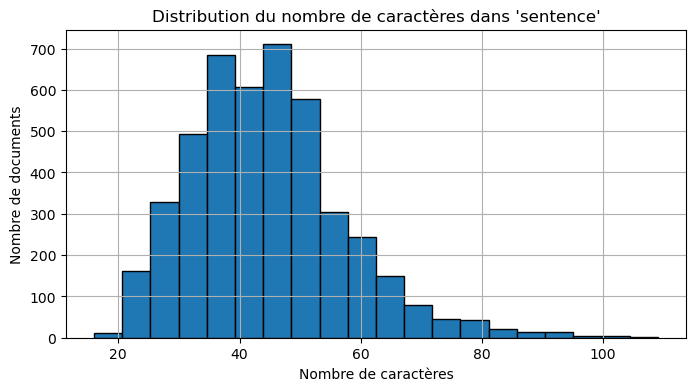

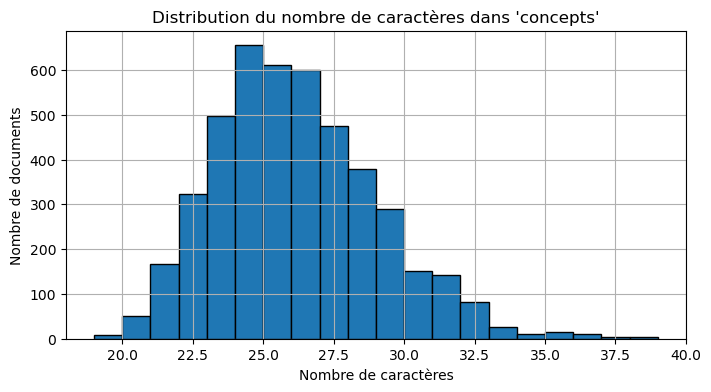

In [28]:
def show_histogram_nb_chararacters(dataset: CustomDataset, column: str):

    """
    Affiche la distribution de la colonne passé en paramètre. L'histogramme doit contenir un titre et des titres sur les axes

    dataset: Dataset contenant plusieurs colonne dont la colonne dont les statistiques doivent être affichées
    column: Colonne à afficher

    """
    # TODO

    # On récupère la colonne
    data = dataset.get_column(column)

    # On récupère la longueur de chaque ligne
    char_lengths = data.apply(len) # les caractères "[" et "]" et "'" ainsi que les espaces sont inclus
    
    # Affichage de l'histogramme
    plt.figure(figsize=(8, 4))
    plt.hist(char_lengths, bins=20, edgecolor='black')
    plt.title(f"Distribution du nombre de caractères dans '{column}'")
    plt.xlabel("Nombre de caractères")
    plt.ylabel("Nombre de documents")
    plt.grid(True)
    plt.show()
    
    # END TODO


show_histogram_nb_chararacters(train_dataset, INPUT_COLUMN)
show_histogram_nb_chararacters(train_dataset, OUTPUT_COLUMN)

#### 2.2 Histogramme du nombre de mots par document (2 points)

De la même manière, complétez la méthode `show_histogram_nb_words` qui affiche un histogramme de la distribution du nombre de mots des exemples de la colonne passée en paramètre. Utilisez des bacs (bins) de 20 pour l'histogramme. Affichez ensuite la distribution du nombre de mots sur l'ensemble d'entraînement pour les colonnes "sentence" et "concepts". Dans le cas de la colonne 'concepts', assurez-vous que les '[', ']' et les apostrophes ne soient pas considérées comme des mots.

Indice : Utilisez la méthode word_tokenize() de nltk.

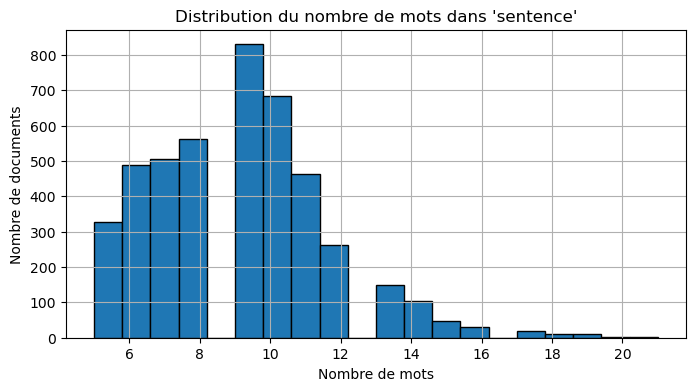

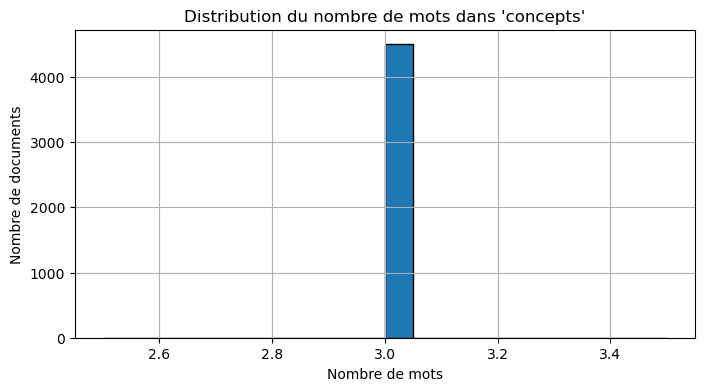

In [29]:
def show_histogram_nb_words(dataset: CustomDataset, column: str):

    """
    Affiche la distribution de la colonne passé en paramètre du dataset. L'histogramme doit contenir un titre et des titres sur les axes

    dataset: Dataset contenant plusieurs colonne dont la colonne dont les statistiques doivent être affichées
    column: Colonne à afficher

    """
    # TODO

    # On récupère la colonne
    data = dataset.get_column(column)

    # On compte le nombre de mots pour chaque ligne avec word_tokenize (après avoir enlevé les caractères spéciaux)
    word_counts = data.apply(lambda x: len(word_tokenize(x.replace('[', '').replace(']', '').replace("'", ''))))
    
    # Affichage de l'histogramme
    plt.figure(figsize=(8, 4))
    plt.hist(word_counts, bins=20, edgecolor='black')
    plt.title(f"Distribution du nombre de mots dans '{column}'")
    plt.xlabel("Nombre de mots")
    plt.ylabel("Nombre de documents")
    plt.grid(True)
    plt.show()
    
    # END TODO

show_histogram_nb_words(train_dataset, INPUT_COLUMN)
show_histogram_nb_words(train_dataset, OUTPUT_COLUMN)

#### 2.3 Commentez les graphiques (1 points)
1. Est-ce que les distributions suivent des distributions normales ?
Non
2. Qu'observez-vous de spécial sur la distribution du nombre de mots de la colonne "concepts" ? Pourquoi est-elle ainsi ? La colonne 'concepts' ne contient toujours que 3 mots.

### 3. Segmentation (Tokenization) (5 points)

#### 3.1 Entraînement du segmenteur (tokenizer) (3 points)
La fonction `word_tokenize()` de `nltk` est utile pour rapidement ressortir des statistiques, mais elle reste très générale et inefficace. Afin de réduire le plus possible la taille du vocabulaire, nous allons entraîner notre propre Tokenizer en nous basant sur l'algorithme BPE (Byte Pair Encoding). L'algorithme BPE est une méthode de compression de texte qui permet de créer des tokenizers efficaces en regroupant les caractères les plus fréquents. Il commence par diviser le texte en caractères uniques, puis itérativement fusionne les paires de caractères les plus fréquentes en nouveaux symboles. Ce processus continue jusqu'à atteindre un nombre prédéfini de jetons (tokens), permettant ainsi de gérer des vocabulaires de différentes tailles de manière flexible et efficace. À l'aide de BPE, nous allons transformer les mots en nombres pour pouvoir les passer au Transformer par la suite. Chaque jeton (token) sera associé à un nombre correspondant à l'indice du jeton dans le vocabulaire. Une séquence en entrée sera ainsi représentée comme une séquence de nombres.

De plus, des jetons spéciaux seront ajoutés au tokenizer pour spécifier le début d'une phrase (begin-of-sequence : `[BOS]`) et la fin d'une phrase (end-of-sequence : `[EOS]`). Un jeton de padding `[PAD]` sera utilisé afin de s'assurer que toutes les phrases ont la même taille. Finalement, un jeton `[UNK]` sera utilisé pour les jetons inconnus.

Pour créer ce vocabulaire à l'aide de l'algorithme BPE, il faudra entraîner le tokenizer sur notre ensemble d'entraînement pour qu'il puisse encoder efficacement les mots qui y sont présents. L'entraînement est déjà implémenté par la classe `ByteLevelBPYTokenizer` de la librairie `tokenizers`.

Vous n'avez qu'à compléter la fonction :
- `data_generator` qui retourne un générateur d'un lot (batch) de texte provenant de l'ensemble d'entraînement. Pour chaque lot, les colonnes "sentence" et "concepts" sont concaténées pour former la chaîne finale qui sera envoyée au tokenizer. Les lots sont utiles lors de l'entraînement pour accélérer l'entraînement en parallélisant le tout et en évitant de charger tout notre ensemble d'entraînement en mémoire directement.

In [30]:
VOCAB_SIZE = 8000
special_tokens = ['[PAD]', '[BOS]', '[EOS]', '[UNK]']
base_tokenizer = CharBPETokenizer(unk_token=special_tokens[-1])
tokenizer_batch_size = 64

def data_generator():
    """
    Generateur qui retourne un lot (batch) de texte provenant de l'ensemble d'entraînement.
    Pour chaque élément d'un lot, les colonnes "sentence" et "concepts" sont concaténée.
    """
    for i in range(0, len(train_dataset), tokenizer_batch_size):

        # TODO

        # On récupère le batch
        batch = train_dataset.get_batch(i, i+tokenizer_batch_size)

        # On concatène les colonnes
        text = batch['sentence'] + batch['concepts'] 
       
        # END TODO

        yield text


Vous devez maintenant compléter la fonction :
- `train_tokenizer` qui prend en paramètre un tokenizer pour entraîner ce dernier à l'aide de la fonction [train_from_iterator](https://github.com/huggingface/tokenizers/blob/main/bindings/python/py_src/tokenizers/implementations/byte_level_bpe.py). Le générateur de données (data_generator) est envoyé à la fonction train_from_iterator tout comme la taille du vocabulaire, les jetons spéciaux et la fréquence minimum d'une séquence pour la considérer comme un jeton. Indiquez explicitement une fréquence minimum de 2.

In [31]:

from tokenizers import AddedToken, Tokenizer, decoders, pre_tokenizers, processors, trainers

def train_tokenizer(tokenizer: CharBPETokenizer):
    """
    Entraîne le tokenizer passé en paramètre en appelant la fonction train_from_iterator
    et en spécifiant le générateur de donnée (data_generator), la taille du vocabulaire,
    les jetons spéciaux et une fréquence minimum de 2 (indiquez le explicitement)
    """
    # TODO

    # Appel de train_from_iterator avec les bons paramètres 
    tokenizer.train_from_iterator(
        iterator=data_generator(),
        vocab_size=VOCAB_SIZE,
        special_tokens=special_tokens,
        min_frequency=2
    )
    
    # END TODO

train_tokenizer(base_tokenizer)

# On ajoute les jetons de début, de fin de phrase et de jeton inconnu
bos_token_id = base_tokenizer.token_to_id("[BOS]")
eos_token_id = base_tokenizer.token_to_id("[EOS]")
unk_token_id = base_tokenizer.token_to_id("[UNK]")

# On applique un template au tokenizer pour qu'il ajoute
# les jetons au début et à la fin de chaque phrase
base_tokenizer.post_processor = processors.TemplateProcessing(
    single=f"[BOS]:0 $A:0 [EOS]:0",
    special_tokens=[
        ("[BOS]", bos_token_id),
        ("[EOS]", eos_token_id),
    ],
)


Nous allons maintenant transformer notre tokenizer pour qu'il soit compatible avec l'API de la librairie Huggingface. Cela permettra entre autre de faciliter les appels de méthodes pour modifier facilement nos entrées. Par exemple, avec l'API de Huggingface, nous pouvons simplement appeler la méthode `tokenize` pour diviser une séquence en jetons (`Welcome` -> `[W, el, come]`). De la même manière, l'API nous permet d'appeler les méthodes `encode` et `decode` pour transformer une chaîne de caractères en séquences d'indices de jetons (`Welcome` -> `[36, 170, 664]`) et inversement.

In [32]:
from transformers import PreTrainedTokenizerFast

tokenizer = PreTrainedTokenizerFast(tokenizer_object=base_tokenizer._tokenizer, truncation=True)
tokenizer.add_special_tokens({
    'pad_token': "[PAD]",
    'bos_token': "[BOS]",
    'eos_token': "[EOS]",
    'unk_token': "[UNK]"
})

0

Testons maintenant notre tokenizer sur une phrase de test

In [33]:
test_input = 'Welcome ! The boat arrived at the station ! 🤗 '
print(test_input, '\n')
print(tokenizer.tokenize(test_input))

Welcome ! The boat arrived at the station ! 🤗  

['W', 'el', 'come</w>', '!</w>', 'The</w>', 'boat</w>', 'arrived</w>', 'at</w>', 'the</w>', 'station</w>', '!</w>', '[UNK]']


Observons maintenant la même phrase, mais une fois encodée en nombre. Décodons-la ensuite à partir de sa version encodée pour voir si nous retrouvons la phrase initiale.

- La méthode `encode` permet de transformer une séquence de mots en séquence de nombres correspondant aux indices des différents jetons de la phrase dans le vocabulaire
- La méthode `decode` permet de transformer une séquence d'indices de jetons en phrase lisible.

In [34]:
print('Texte initial : ', test_input)
print('=' * 100)
print('Texte encodé : ', tokenizer.encode(test_input))
print('Texte décodé : ', tokenizer.decode(tokenizer.encode(test_input)))

Texte initial :  Welcome ! The boat arrived at the station ! 🤗 
Texte encodé :  [1, 36, 168, 807, 95, 277, 295, 2875, 129, 118, 350, 95, 3, 2]
Texte décodé :  [BOS]Welcome ! The boat arrived at the station ! [UNK][EOS]


#### 3.2 Que remarquez-vous dans la version segmentée (tokenized) de la phrase de test ? Quelles sont les différences entre la phrase initiale et la phrase décodée ? Pourquoi ? (2 points)

### 4. Transformer (28 points)

Il est maintenant le temps de construire les couches du Transformer. Son architecture globale est présentée dans la figure suivante. :

![Transformer](images/transformer.png)

Les couches sont définies pour vous et vous n'avez qu'à compléter, à moins d'indication contraire, la fonction `forward` de chacune des classes qui prend un tenseur en entrée et effectue une transformation sur celui-ci pour générer une sortie. Cette transformation varie en fonction de chaque classe. Une description de ce que doit faire la classe est indiquée à chaque étape. Lorsque la fonction `forward` est complexe, une figure est fournie pour vous guider. Attention, ne changez pas le constructeur ou le nom de la classe !

#### 4.1 Positional Embedding
Le Transformer encode l'information de l'ordre des mots dans les plongements des mots. Des plongements de position sont calculés et ils sont ajoutés aux plongements de contexte. Dans ce cas-ci la classe `PositionalEmbedding` vous est donnée.

In [35]:
class PositionalEmbedding(nn.Module):
    """
    Cette classe a été prise de l'implémentation originale du papier 'Attention Is All You Need'
    """

    def __init__(self, max_seq_length, embedding_dim):
        super(PositionalEmbedding, self).__init__()

        self.max_seq_length = max_seq_length
        self.embedding_dim = embedding_dim

        pe = torch.zeros(max_seq_length, self.embedding_dim)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.embedding_dim, 2).float() * -(math.log(10000.0) / self.embedding_dim))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x: torch.Tensor):
        return x + self.pe[:, :x.size(1)]


#### 4.2 Attention (6 points)
Le mécanisme d'attention est le coeur de l'architecture du Transformer. Il permet notamment la parallélisation de l'entraînement tout en garantissant un lien direct entre tous les jetons. Vous devrez implémenter la fonction `scaled_dot_product_attention` qui effectue le calcul principal derrière le mécanisme d'attention. Cette fonction prend en entrée les tenseurs `Q`, `K`, `V` et effectue le calcul suivant :
$$A = \texttt{softmax}\Big( \frac{Q K^T \odot M}{\texttt{head\_dim}} \Big) V$$
où $M$ est le masque d'attention qui doit être appliqué. Plus de détails sont indiqués dans la description de la fonction à propos du masque. Par rapport au tenseur de clés, vous remarquerez dans la formule qu'une transposée est appliquée sur ce tenseur. Étant donné qu'un tenseur possède plus que 2 dimensions, il est important de spécifier quelles dimensions seront transposées dans le tenseur. Dans notre cas, il s'agit des dimensions correspondants aux jetons de la séquence et aux plongements des jetons

In [36]:
class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert model_dim % num_heads == 0, "La dimension du modèle doit être divisible par le nombre de têtes d'attention"

        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads

        self.wq = nn.Linear(model_dim, model_dim) # Query
        self.wk = nn.Linear(model_dim, model_dim) # Key
        self.wv = nn.Linear(model_dim, model_dim) # Value
        self.wo = nn.Linear(model_dim, model_dim) # Output

        self.mask_value = -1e9

    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        """
        Calcule les plongements d'attention en utilisant la formule

        attn = softmax(Q * K^T @ mask / head_dim) * V

        Args :
            Q : plongements des queries
            Taille : [batch_size, num_heads, seq_length, head_dim]

            K : plongements des keys
            Taille : [batch_size, num_heads, seq_length, head_dim]

            V : plongement des values
            Taille : [batch_size, num_heads, seq_length, head_dim]

            mask : Masque d'attention qui doit être appliqué avant le softmax pour que
            les jetons ne portent pas leur attention sur certains jetons. Le masque est
            notamment utilisé dans le décodeur pour s'assurer que le transformer n'ait
            pas accès aux futurs jetons lorsqu'il essaie de prédire le prochain jeton.
            Il contient des valeurs 0 ou 1. Une valeur de 0 à la position i,j indique
            que pour le jeton i, le jeton j doit être masqué. Pour masquer la valeur,
            il suffit de mettre une valeur très petite (self.mask_value) à l'indice i,j.
            La fonction masked_fill de PyTorch pourrait être utile
            Taille : [1, seq_length, seq_length]

        Returns :
        Résultat du calcul d'attention de taille [batch_size, num_heads, seq_length, head_dim]
        """
        # TODO

        # Q * K^T / head_dim
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / self.head_dim**0.5
        
        # On applique le masque
        attn_scores_masked = attn_scores.masked_fill(mask == 0, self.mask_value)

        # Softmax
        attn_weights = F.softmax(attn_scores_masked, dim=-1)

        # On multiplie par V
        attn = torch.matmul(attn_weights, V)

        return attn    
        
        # END TODO

    def split_heads(self, x):
        """
        Sépare une entrée sur plusieurs têtes d'attention

        Args :
            x : Tenseur d'entrée
            Taille : [batch_size, seq_length, model_dim]

        Returns :
        Tenseur séparé sur plusieurs têtes d'attention
        Taille : [batch_size, num_heads, seq_length, head_dim]
        """
        return x.view(x.shape[0], x.shape[1], self.num_heads, self.head_dim).transpose(1, 2)

    def combine_heads(self, x):
        """
        Combine une entrée à travers les têtes d'attention

        Args :
            x : Tenseur d'entrée
            Taille : [batch_size, num_heads, seq_length, head_dim]

        Returns :
        Tenseur séparé sur plusieurs têtes d'attention
        Taille : [batch_size, seq_length, model_dim]
        """
        return x.transpose(1, 2).contiguous().view(x.shape[0], x.shape[2], self.model_dim)

    def forward(self, queries, keys, values, mask=None):
        """
        Exécute le mécanisme d'attention à travers plusieurs têtes
        d'attention

        Args :
            queries : plongements des queries
            Taille : [batch_size, seq_length, model_dim]

            keys : plongements des keys
            Taille : [batch_size, seq_length, model_dim]

            values : plongement des values
            Taille : [batch_size, seq_length, model_dim]

            mask : mask qui sera appliqué
            Taille : [1, seq_length, seq_length]

        Returns :
        Tenseur contenant les plongements finaux de chaque indice de
        la séquence
        Taille : [batch_size, seq_length, model_dim]
        """
        
        Q = self.split_heads(self.wq(queries))
        K = self.split_heads(self.wk(keys))
        V = self.split_heads(self.wv(values))

        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        return self.wo(self.combine_heads(attn_output))

In [37]:
def test_attention():
    batch_size = 1
    seq_length = 4
    model_dim = 6
    num_heads = 2

    torch.random.manual_seed(42)
    attention = MultiHeadAttention(model_dim=model_dim, num_heads=num_heads)
    inputs = torch.randint(0, 10, (batch_size, seq_length, model_dim), dtype=torch.float32)
    mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1))
    print(attention.forward(inputs, inputs, inputs, mask=mask).detach())

test_attention()

tensor([[[-0.6789,  2.8487,  2.8666, -1.1983,  3.2915,  0.5359],
         [-0.3437,  3.1045,  3.0715, -1.1405,  3.2748,  0.3843],
         [-2.5825,  4.2728, -0.0114, -2.2663, -0.0922, -2.4731],
         [-2.5749,  4.2706, -0.0056, -2.2613, -0.0874, -2.4694]]])


Sortie attendue :
```
tensor([[[-0.6789,  2.8487,  2.8666, -1.1983,  3.2915,  0.5359],
         [-0.3437,  3.1045,  3.0715, -1.1405,  3.2748,  0.3843],
         [-2.5825,  4.2728, -0.0114, -2.2663, -0.0922, -2.4731],
         [-2.5749,  4.2706, -0.0056, -2.2613, -0.0874, -2.4694]]])
```

#### 4.3 Encodeur (6 points)
L'encodeur du Transformer encode la séquence d'entrée dans des vecteurs de contexte avant d'envoyer ces vecteurs de contexte au décodeur pour qu'ils puissent être utilisés pour générer la séquence de sortie. Vous n'avez qu'à compléter les fonctions `forward` des classes `TransformerFeedForward`, `EncoderLayer` et `Encoder`. L'architecture d'une couche d'encodeur `EncoderLayer` est décrite dans la figure suivante :

![EncoderLayer](images/encoder_layer.png)

La classe `TransformerFeedForward` représente une couche simple de réseaux de neurones avec la fonction d'activation `ReLU` qui sera présente dans l'encodeur. Son architecture est décrite dans la figure suivante :

![TransformerFeedForward](images/transformer_feed_forward.png)

In [38]:
class TransformerFeedForward(nn.Module):

    def __init__(self, model_dim: int, ff_dim: int) -> None:
        super(TransformerFeedForward, self).__init__()
        self.model_dim = model_dim
        self.ff_dim = ff_dim

        self.ff1 = nn.Linear(model_dim, ff_dim)
        self.ff2 = nn.Linear(ff_dim, model_dim)

    def forward(self, x: torch.Tensor):
        """
        Applique les deux couches linéaires (ff) consécutivement avec la fonction
        d'activation ReLU après chaque couche linéaire

        Args :
            x : Tenseur d'entrée de taille [batch_size, model_dim]

        Returns :
        Tenseur après être passé à travers les couches linéaires de taille
        [batch_size, model_dim]
        """
        # TODO

        # Couche ff1
        x = self.ff1(x)

        # Couche ReLU
        x = torch.relu(x)

        # Couche ff2
        x = self.ff2(x)

        # Couche ReLU
        x = torch.relu(x)

        return x 
        # END TODO

La classe `EncoderLayer` représente une seule couche qui applique le mécanisme d'attention sur la sortie de la couche précédente. Dans le cas de la première couche d'encodeur, il s'agit simplement de la couche de plongements des jetons. Par la suite, le résultat du mécanisme d'attention est normalisé et envoyé à une couche de réseau de neurones.

In [39]:
class EncoderLayer(nn.Module):

    def __init__(self, model_dim: int, ff_dim: int, dropout_rate: int = 0.3, num_heads=8) -> None:
        super(EncoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(model_dim=model_dim, num_heads=num_heads)
        self.feed_forward = TransformerFeedForward(model_dim=model_dim, ff_dim=ff_dim)
        self.attention_layer_norm = nn.LayerNorm(model_dim)
        self.ff_layer_norm = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x: torch.Tensor, encoder_mask: torch.Tensor = None):
        """
        Applique la couche d'attention, de normalisation et de réseau de neurones
        sur l'entrée

        Args :
            x : Tenseur d'entrée de l'encodeur correspondant à la séquence d'entrée
            Taille : [batch_size, seq_length, model_dim]

        Returns :
        Tenseur après avoir appliqués les couches de taille [batch_size, seq_length,
        model_dim]
        """
        # TODO

        # Couche de Self-attention
        attention_output = self.self_attention(x, x, x, mask=encoder_mask)

        # Couche Dropout
        attention_output = self.dropout(attention_output)
        
        # Couche Add & Norm
        x = self.attention_layer_norm(x + attention_output)
    
        # Couche Feed Forward
        ff_output = self.feed_forward(x)
        
        # Couche Dropout
        ff_output = self.dropout(ff_output) 

        # Couche Add & Norm
        x = self.ff_layer_norm(x + ff_output) 

        return x 
    
        # END TODO

La classe `Encoder` correspond à une suite de plusieurs couches d'encodeurs. La fonction `forward` de cette classe doit appeler chacune des couches (`EncoderLayer`) une à la suite de l'autre en passant à la couche courante la sortie de la couche précédente. Le masque est partagé entre toutes les couches `EncoderLayer`.

In [40]:
class Encoder(nn.Module):

    def __init__(self, num_layers: int, model_dim: int, ff_dim: int, dropout_rate: int = 0.3, num_heads=8) -> None:
        super(Encoder, self).__init__()

        self.layers = nn.ModuleList(
            [EncoderLayer(
                model_dim=model_dim,
                ff_dim=ff_dim,
                dropout_rate=dropout_rate,
                num_heads=num_heads,
            ) for _ in range(num_layers)]
        )

    def forward(self, x: torch.Tensor, encoder_mask: torch.LongTensor = None):
        """
        Applique toutes les couches d'encodeur consécutivement

        Args :
            x : Tenseur d'entrée de l'encodeur correspondant à la séquence d'entrée
            Taille : [batch_size, seq_length, model_dim]

            encoder_mask : Tenseur contenant le masque qui sera utilisé par l'encodeur
            pour cacher certains jetons (notamment les jetons [PAD])
        Returns :
        Tenseur après avoir appliqués les couches dans l'encodeur de taille
        [batch_size, seq_length, model_dim]
        """
        # TODO 

        # Appel de chaque couche :
        # *on passe la sortie courante à la couche supérieure
        # *on partage le masque entre les couches

        for layer in self.layers:
            x = layer(x, encoder_mask) 
        return x
    
        # END TODO

#### 4.4 Décodeur (8 points)
Le décodeur est la partie du Transformer qui génère la séquence de sortie en prenant le contexte de la séquence d'entrée et les jetons qui ont été générés précédemment. De la même manière que l'encodeur, la classe `DecoderLayer` représente une seule couche de décodeur. L'architecture du `DecoderLayer` est présentée dans la figure suivante :

![DecoderLayer](images/decoder_layer.png)

In [41]:
class DecoderLayer(nn.Module):

    def __init__(self, model_dim: int, ff_dim: int, dropout_rate: int = 0.3, num_heads=8) -> None:
        super(DecoderLayer, self).__init__()

        self.self_attention = MultiHeadAttention(model_dim=model_dim, num_heads=num_heads)
        self.cross_attention = MultiHeadAttention(model_dim=model_dim, num_heads=num_heads)

        self.feed_forward = TransformerFeedForward(model_dim=model_dim, ff_dim=ff_dim)

        self.self_attention_layer_norm = nn.LayerNorm(model_dim)
        self.cross_attention_layer_norm = nn.LayerNorm(model_dim)
        self.ff_layer_norm = nn.LayerNorm(model_dim)

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self,
                x: torch.Tensor,
                encoder_out: torch.Tensor,
                encoder_mask: torch.LongTensor = None,
                decoder_mask: torch.LongTensor = None):
        """
        Applique les couches d'attention, de normalisation et de réseau de neurones
        sur l'entrée

        Args :
            x : Entrée du décodeur correspondant à la séquence de sortie décalée vers
            la droite
            Taille : [batch_size, seq_length, model_dim]

            encoder_output : Sortie de l'encodeur utilisé pour la couche de cross-
            attention
            Taille : [batch_size, seq_length, model_dim]

            encoder_mask : Masque qui cache certains jetons dans la séquence d'entrée.
            Par exemple, les jetons [PAD] seront cachés puisqu'ils ne sont utilisés que
            pour aggrandir les séquences jusqu'à la fenêtre de contexte du Transformer
            Taille : [batch_size, seq_length, seq_length]

            decoder_mask : Masque qui cache certains jetons dans la séquence de sortie.
            Ce masque est notamment utilisé dans le décodeur pour s'assurer que le
            transformer n'ait pas accès aux futurs jetons lorsqu'il essaie de prédire
            le prochain jeton.
            Taille : [batch_size, seq_length, seq_length]
        """
        # TODO

        # Couche de Self-attention 
        self_attention_out = self.self_attention(x, x, x, mask = decoder_mask)
        # Couche Dropout
        self_attention_out = self.dropout(self_attention_out)
        # Couche Add & Normalize
        self_attention_out = self.ff_layer_norm(x + self_attention_out)

        # Couche de Cross-attention 
        encoder_attention_out = self.cross_attention(self_attention_out, encoder_out, encoder_out, mask = encoder_mask) # On utilise la sortie de l'encodeur pour les clés et valeurs pour l'attention croisée
        # Couche Dropout
        encoder_attention_out = self.dropout(encoder_attention_out)
        # Add & Norm
        encoder_attention_out = self.ff_layer_norm(encoder_attention_out + self_attention_out)
        
        # Couche Feed Forward
        ff_out = self.feed_forward(encoder_attention_out)
        # Couche Dropout
        ff_out = self.dropout(ff_out)
        # Couche Add & Norm
        out = self.ff_layer_norm(ff_out + encoder_attention_out)

        return out
        # END TODO

La classe `Decoder` représente toutes les couches du décodeur. La fonction `forward` de cette classe doit appeler chacune des couches (`DecoderLayer`) une à la suite de l'autre en passant à la couche courante la sortie de la couche précédente. Les attributs `encoder_out`, `encoder_mask` et `decoder_mask` sont partagés entre toutes les couches `DecoderLayer`.

In [42]:
class Decoder(nn.Module):

    def __init__(self, num_layers: int, model_dim: int, ff_dim: int, dropout_rate: int = 0.3, num_heads=8) -> None:
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
            [DecoderLayer(
                model_dim=model_dim,
                ff_dim=ff_dim,
                dropout_rate=dropout_rate,
                num_heads=num_heads,
            ) for _ in range(num_layers)]
        )

    def forward(self, x: torch.Tensor, encoder_out: torch.Tensor, encoder_mask: torch.LongTensor = None, decoder_mask: torch.LongTensor = None):
        """
        Applique toutes les couches du décodeur consécutivement

        Args :
            x : Tenseur d'entrée du décodeur correspondant à la séquence de sortie
            Taille : [batch_size, seq_length, model_dim]

            encoder_out : Tenseur contenant la séquence d'entrée encodée par l'encodeur

            encoder_mask : Tenseur contenant le masque qui sera utilisé par l'encodeur
            pour cacher certains jetons (notamment les jetons [PAD])

            decoder_mask : Tenseur contenant le masque qui sera utilisé par le décodeur
            pour cacher certains jetons (notamment les jetons [PAD] et les jetons futurs)

        Returns :
        Tenseur après avoir appliqués les couches dans l'encodeur de taille
        [batch_size, seq_length, model_dim]
        """
        # TODO

        # Appel de chaque couche :
        # *on passe la sortie courante à la couche supérieure
        # *on partage les masques et encoder_out entre les couches
        for layer in self.layers:
            x = layer(x, encoder_out, encoder_mask, decoder_mask)
        return x
    
        # END TODO

#### 4.5 Transformer (8 points)

L'architecture du Transformer est maintenant prête à être assemblée. En utilisant les différentes couches que vous avez implémentées, complétez la fonction `forward` de la classe `Transformer` qui, à partir de l'entrée de l'encodeur et du décodeur, génère la sortie du décodeur. L'architecture, telle que présentée précédemment, correspond à la figure suivante :

![Transformer](images/transformer.png)

La fonction forward doit passer les entrées à l'encodeur et au décodeur pour pouvoir générer une prédiction en fonction d'une entrée en appliquant les bons masques et encodages de position.

In [43]:
@dataclass
class TransformerConfig:

    model_dim: int = 512
    ff_dim: int = 2048

    nb_encoder: int = 6
    nb_decoder: int = 6

    num_heads: int = 8

    max_seq_length: int = MAX_LENGTH
    vocab_size: int = VOCAB_SIZE
    device: str = 'cpu'
    pad_token_id: int = 0


class Transformer(nn.Module):

    def __init__(self, config: TransformerConfig) -> None:
        super(Transformer, self).__init__()

        self.config = config
        self.enc_embeddings = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.model_dim
        )

        self.dec_embeddings = nn.Embedding(
            num_embeddings=config.vocab_size,
            embedding_dim=config.model_dim
        )

        self.positional_embeddings = PositionalEmbedding(
            max_seq_length=config.max_seq_length,
            embedding_dim=config.model_dim
        )

        self.encoder = Encoder(config.nb_encoder, config.model_dim, config.ff_dim, num_heads=config.num_heads)
        self.decoder = Decoder(config.nb_decoder, config.model_dim, config.ff_dim, num_heads=config.num_heads)

        self.linear_projection = nn.Linear(config.model_dim, config.vocab_size)
        self.device = config.device

    def generate_mask(self, src, tgt):
        """
        Génère les masques d'attentions pour l'encodeur et le décodeur du transformer en
        se basant sur le jeton de pad donné dans la configuration du transformer. Dans le
        cas du décodeur, un masque causal est également calculé pour empêcher les jetons
        de porter leur attention sur les jetons futurs

        Args :
            src : Séquence d'entrée

        """
        src_mask = (src != self.config.pad_token_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != self.config.pad_token_id).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(self.device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, encoder_x: torch.Tensor, decoder_x: torch.Tensor):
        """
        Génère la sortie du décodeur étant donné une entrée pour l'encodeur et une entrée
        pour le décodeur

        Args :
            encoder_x : Tenseur d'entrée de l'encodeur
            Taille : [batch_size, seq_length]

            decoder_x : Tenseur d'entrée du décodeur
            Taille : [batch_size, seq_length]

        Returns :
        Sortie du décodeur correspondant au prédictions du jeton le plus proche. Attention,
        n'appliquez pas softmax sur ces prédictions. Ce tenseur devrait avoir une taille de
        [batch_size, seq_length, vocab_size]
        """

        # TODO
        
        # Récupération des masques
        encoder_mask, decoder_mask = self.generate_mask(encoder_x, decoder_x)

        # Entrée pour l'encodeur (enc_embeddings + positional_embeddings)
        encoder_x = self.positional_embeddings(self.enc_embeddings(encoder_x))
        # Application et sortie de l'encodeur
        encoder_x = self.encoder(encoder_x, encoder_mask)

        # Entrée pour le décodeur (enc_embeddings + positional_embeddings)
        decoder_x = self.positional_embeddings(self.enc_embeddings(decoder_x))
        # Application et sortie du décodeur
        decoder_x = self.decoder(decoder_x, encoder_x, encoder_mask, decoder_mask)

        # Couche linéaire finale (projection dans l'espace du vocabulaire)
        decoder_y = self.linear_projection(decoder_x)
        
        return decoder_y
    
        # END TODO

### 5. Padding et coupure (5 points)

Il est important, lors de l'entraînement que toutes les séquences aient la même longueur de texte, car le Transformer prend toujours un nombre fixe de jetons. Cette taille correspond à sa fenêtre de contexte. Afin de s'assurer que toutes les séquences de texte dans un lot d'entraînement soient de la même longueur, nous allons couper les séquences trop longues et ajouter des jetons à celles qui sont trop courtes. Le jeton qui sera ajouté sera le jeton de "padding" du tokenizer (`[PAD]`).

Complétez la fonction `tokenize` de la classe `DataCollator` qui s'occupe d'appeler le tokenizer avec les textes passés en paramètre en spécifiant les paramètres suivants :
- `padding`: `"max_length"` (Attention on veut la chaîne de charactère `"max_length"`, pas la variable)
- `truncation`: `True`
- `max_length`: La taille maximale passée dans le constructeur
- `return_tensors`: `pt`
- `return_token_type_ids`: `False`
- `add_special_tokens`: `True`

Complétez la fonction `__call__` qui s'occupe de prendre un lot de données (le lot/batch correspondant à un sous-ensemble de l'ensemble d'entraînement) et retourne les entrées de l'encodeur et du décodeur ainsi que la sortie du décodeur du Transformer. Vous devrez prendre le lot passé en paramètre et transformer les colonnes `sentence` et `concepts` du lot en jetons. Les jetons de la colonne `sentence` seront envoyés à l'encodeur et les jetons de la colonne `concepts` seront envoyés au décodeur.

In [44]:
from typing import Dict, List, Union


class DataCollator:
    def __init__(self, tokenizer: Tokenizer, max_length: int, device: str = 'cpu') -> None:
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.device = device

        self.pad_token_id = tokenizer.pad_token_id
        self.bos_token_id = tokenizer.bos_token_id
        self.eos_token_id = tokenizer.eos_token_id

    def tokenize(self, texts):
        """
        Transforme la séquence de textes en séquence d'indice de jetons

        Args :
            texts : Textes à transformer

        Returns :
        Indices des jetons des textes
        """
        # TODO

        # Appel du tokenizer avec les bons paramètres
        return self.tokenizer(texts, padding =  "max_length", truncation = True, max_length = self.max_length, return_tensors = 'pt', return_token_type_ids = False, add_special_tokens = True)
    
        # END TODO

    def __call__(self, batch: List[Dict[str, Union[str, int]]]) -> Dict[str, torch.Tensor]:
        """
        Transforme une batch contenant les colonnes target et concepts en les envoyant au tokenizer
        et préparant les jetons aux entrées et sorties de l'encodeur et du décodeur
        """
        # TODO

        # On tokenize les sentences
        sentences = [item['sentence'] for item in batch]
        encoder = self.tokenize(sentences)
        
         # On tokenize les concepts
        concepts = [item['concepts'] for item in batch]
        decoder = self.tokenize(concepts)      
    

        """
        Dans le décodeur, la séquence attendue est décalée vers la droite d'un jeton à l'entrée du décodeur.
        Par exemple, si on veut faire de la traduction, nous pourrions avoir la séquence suivante :

        La pomme est verte -> The apple is green

        Les valeurs du dictionnaire de retour serait donc :

        +-------------+--------+--------+--------+--------+--------+--------+
        |   Valeur    | Jeton1 | Jeton2 | Jeton3 | Jeton4 | Jeton5 | Jeton6 |
        +-------------+--------+--------+--------+--------+--------+--------+
        | encoder_in  | [BOS]  | la     | pomme  | est    | verte  | [EOS]  |
        | decoder_in  | [BOS]  | The    | apple  | is     | green  | [EOS]  |
        | decoder_out | The    | apple  | is     | green  | [EOS]  | [PAD]  |
        +-------------+--------+--------+--------+--------+--------+--------+

        Par exemple, pour le jeton 3, le transformer essaiera de prédire le jeton "is" avec comme information
        tous les jetons de l'encodeur et tous les jetons précédents le "is" ([BOS] The apple).

        C'est d'ailleurs à cause de ce décalage que nous enlevons le premier jetons dans 'decoder_out'. Aussi,
        le dernier jetons dans 'decoder_in' est enlevé, car le Transformer ne devrait jamais voir le jeton
        de fin de phrase, car cela voudrait dire que la séquence est terminée. Il devrait seulement le prédire.
        """

        # Préparation des jetons pour les entrées et sorties de l'encodeur et du décodeur avec les décalages necéssaires
        return {
            'encoder_in': encoder['input_ids'].to(self.device), 'decoder_in': decoder['input_ids'][:, :-1].to(self.device),       
            'decoder_out': decoder['input_ids'][:, 1:].to(self.device),        
        }             
        # END TODO
        


In [45]:
def test_data_collator():
    data_collator = DataCollator(tokenizer=tokenizer, max_length=16)
    sample_data = test_dataset[:2]
    result = data_collator(CustomDataset(data=sample_data))
    print('=' * 100)
    print()
    print('Encoder in detokenized : \n\n', '\n'.join(tokenizer.batch_decode(result['encoder_in'])))
    print()
    print('Decoder in detokenized : \n\n', '\n'.join(tokenizer.batch_decode(result['decoder_in'])))
    print()
    print('Decoder out detokenized : \n\n', '\n'.join(tokenizer.batch_decode(result['decoder_out'])))
    print()
    print('=' * 100)

test_data_collator()


Encoder in detokenized : 

 [BOS]two elephants standing next to each other in their pen [EOS][PAD][PAD][PAD][PAD]
[BOS]A big elephant that is standing there quietly in the pen . [EOS]

Decoder in detokenized : 

 [BOS][ ' elephant ' ' pen ' ' stand ' ] [EOS][PAD][PAD]
[BOS][ ' elephant ' ' pen ' ' stand ' ] [EOS][PAD][PAD]

Decoder out detokenized : 

 [ ' elephant ' ' pen ' ' stand ' ] [EOS][PAD][PAD][PAD]
[ ' elephant ' ' pen ' ' stand ' ] [EOS][PAD][PAD][PAD]



Sortie attendue :
```
====================================================================================================

Encoder in detokenized :

 [BOS]two elephants standing next to each other in their pen [EOS][PAD][PAD][PAD][PAD]
[BOS]A big elephant that is standing there quietly in the pen. [EOS]

Decoder in detokenized :

 [BOS]['elephant'' pen'' stand'] [EOS][PAD][PAD]
[BOS]['elephant'' pen'' stand'] [EOS][PAD][PAD]

Decoder out detokenized :

 ['elephant'' pen'' stand'] [EOS][PAD][PAD][PAD]
['elephant'' pen'' stand'] [EOS][PAD][PAD][PAD]

====================================================================================================
```

### 6. Création de lots (Batching)

Nous allons utiliser la classe `DataLoader` de PyTorch pour charger les données en "batchs". La classe `DataCollator` sera passée en paramètre lors du chargement des données pour automatiquement transformer le texte en jetons.

In [46]:
BATCH_SIZE = 256
TEST_BATCH_SIZE = 128

collator = DataCollator(tokenizer=tokenizer, max_length=MAX_LENGTH, device=DEVICE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collator)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collator)
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, collate_fn=collator)

### 7. Entraînement (26 points)

#### 7.1 Boucle d'entraînement (20 points)

Pour pouvoir générer des prédictions qui ont du sens, il faut entraîner le modèle à effectuer ces prédictions à partir des données d'entraînement. Pour cela, la classe `Trainer` sera utilisée. Elle permettra au modèle, à partir de données d'entraînement, d'apprendre la bonne combinaison de paramètres qui effectue les meilleures prédictions. Nous validerons ensuite les prédictions avec l'ensemble de test. L'ensemble de validation sera utilisé durant l'entraînement pour s'assurer que le modèle apprend bien.

Compléter les fonctions `train_epoch` et `validation_epoch` de la classe `Trainer` pour permettre au transformer passé en paramètre du constructeur d'être entraîné avec les données d'entraînement.

La fonction `train_epoch` doit :
- Parcourir toutes les lots (batchs) d'entraînement et pour chaque lot :
  - Entraîner le modèle pour ce lot en évaluant la fonction de perte et mettant à jour les paramètres en fonction des gradients
- Calculer la perte d'entraînement moyenne
- Mettre la perte d'entraînement dans un objet de la classe `History`

La fonction `validation_epoch` doit :
- Parcourir tous les lots de validation et pour chaque lot :
  - Évaluer le modèle sur ce lot en évaluant la fonction de perte
- Calculer la perte de validation moyenne
- Mettre la perte de validation dans un objet de la classe `History`

In [47]:
from tqdm import tqdm

class History:

    def __init__(self):
        self.t_loss = []
        self.v_loss = []
        self.time_to_train = -1

class Trainer:

    def __init__(self,
                 transformer: Transformer,
                 train_loader: DataLoader,
                 val_loader: DataLoader,
                 num_epochs: int,
                 loss_function = None,
                 device='cpu',
                 saving_path='model') -> None:
        """
        Args :
            transformer: Modèle qui sera entraîné

            train_loader: Objet contenant les données d'entraînement en batch

            val_loader: Objet contenant les données de validation en batch

            num_epochs: Nombre d'étape d'entraînement (une étape équivaut à
            parcourir toutes les données une fois)

            loss_function: Fonction de perte utilisée lors de l'entraînement. Si
            le paramètre est laissé à `None`, la fonction d'entropie croisée sera
            utilisée en ignorant les jetons de pad (retrouvés avec la config du modèle)

            device: Machine sur laquelle le modèle sera entraîné
        """

        self.model = transformer
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_epochs = num_epochs
        self.device = device
        self.saving_path = saving_path

        self.optimizer = O.Adam(self.model.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

        if loss_function is None:
            self.loss_function = nn.CrossEntropyLoss(ignore_index=transformer.config.pad_token_id).to(self.device)
        else:
            self.loss_function = loss_function

    def compute_loss(self, logits: torch.Tensor, labels: torch.Tensor):
        """
        Trouve la valeur de la fonction de perte (self.loss_function)
        étant donné les probabilités (logits) prédits et les vraies
        valeurs (labels)

        Args :
            logits:     Probabilités prédites par le modèle sur le prochain
                        jeton pour chacun des jetons de la séquence
                        Tenseur de taille : [batch_size, seq_length, vocab_size]

            labels:     Jetons qui devraient être prédis comme les prochains
                        jetons pour chaque jeton de la séquence
                        Tenseur de taille : [batch_size, seq_length]
        """

        _, _, vocab_size = logits.shape
        return self.loss_function(logits.contiguous().view(-1, vocab_size), labels.contiguous().view(-1))

    def train_epoch(self, history):
        """
        Entraîne le modèle sur tous les lots du `self.train_loader` et calcule
        la perte d'entraînement moyen en l'ajoutant à l'objet history passé en
        paramètre

        Args :
            history :   Objet contenant les statistiques d'entraînement d'un modèle
        """

        # TODO
        total_loss = 0
        for batch in self.train_loader :

            # Récupérer les entrées à partir des données d'entrainement
            encoder_inputs = batch['encoder_in'].to(self.device)
            decoder_inputs = batch['decoder_in'].to(self.device)
            decoder_targets = batch['decoder_out'].to(self.device)
            
            # Appeler le modèle
            outputs = self.model(encoder_inputs, decoder_inputs)

            # Evaluer la perte et mettre à jour les paramètres
            loss = self.compute_loss(outputs, decoder_targets)
            self.optimizer.zero_grad()  
            loss.backward()         
            self.optimizer.step()
            total_loss+=loss.item()
            
        # Stocker la perte d'entrainement moyenne dans history
        avg_loss = total_loss / len(self.train_loader)
        history.t_loss.append(avg_loss) 
                
        # END TODO

    def validation_epoch(self, history):
        """
        Évalue le modèle sur tous les lots du `self.val_loader` et calcule
        la perte de validation moyen en l'ajoutant à l'objet history passé en
        paramètre

        Args :
            history :   Objet contenant les statistiques d'entraînement d'un modèle
        """

        # TODO
        with torch.no_grad() :
            total_loss = 0
            for batch in self.val_loader :

                # Récupérer les entrées à partir des données de validation
                encoder_inputs = batch['encoder_in'].to(self.device)
                decoder_inputs = batch['decoder_in'].to(self.device)
                decoder_targets = batch['decoder_out'].to(self.device)
                
                # Appeler le modèle                
                outputs = self.model(encoder_inputs, decoder_inputs)

                # Evaluer la perte
                loss = self.compute_loss(outputs , decoder_targets)     
                total_loss+=loss.item()

            # Stocker la perte de validation moyenne dans history
            avg_loss = total_loss / len(self.val_loader)
            history.v_loss.append(avg_loss)
        # END TODO


    def train(self) -> History:
        """
        Entraîne `self.model` en utilisant les données de `self.train_loader`

        Returns :
        Historique contenant les perte d'entraînement et de validation moyennes
        pour chaque étape (epoch) d'entraînement
        """
        history = History()
        start = time.time()
        self.model.to(self.device)


        for epoch in tqdm(range(self.num_epochs)):

            self.train_epoch(history)
            self.validation_epoch(history)

            print(f'Epoch {epoch} / {self.num_epochs} : train_loss = {history.t_loss[-1]}, val_loss = {history.v_loss[-1]}')

            if epoch > 0 and epoch % 10 == 0:
                self.save(f'{self.saving_path}_{epoch}.pt')

        end = time.time()
        history.time_to_train = end - start
        self.save(f'{self.saving_path}_{self.num_epochs}.pt')
        return history

    def save(self, path: str):
        """
        Saves the model in the specified path
        """
        torch.save(self.model.state_dict(), path)

    @staticmethod
    def load(config: TransformerConfig, path: str):
        """
        Loads the model from the specified path
        """
        model = Transformer(config)
        model.load_state_dict(torch.load(path))
        return model

#### 7.2 Nombre de paramètres (2 points)
Complétez maintenant la fonction `count_parameters` permettant de calculer le nombre de paramètres du modèle

In [48]:
def count_parameters(model):
    """
    Calcule le nombre de paramètres que l'on peut entraîner dans un modèle

    Args :
        model : Modèle dont on veut savoir le nombre de paramètres

    Returns :
    Nombre de paramètres
    """
    # TODO
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return trainable_params
    # END TODO

config = TransformerConfig()
config.device = DEVICE
model = Transformer(config)

print('Nombre de paramètres : ', count_parameters(model))

Nombre de paramètres :  56434496


#### 7.3 Entraînement (4 points)
Entraînez maintenant le modèle pour 30 époques

In [49]:
# TODO
trainer_model = Trainer(model, train_loader, val_loader, 30, None, 'cuda')
history = History() # Mettez le résultat de l'entraînement dans cette variable
history = trainer_model.train()
# END TODO

  3%|▎         | 1/30 [00:04<02:14,  4.62s/it]

Epoch 0 / 30 : train_loss = 3.853588859240214, val_loss = 2.923761248588562


  7%|▋         | 2/30 [00:09<02:06,  4.52s/it]

Epoch 1 / 30 : train_loss = 2.356068584654066, val_loss = 2.5498310327529907


 10%|█         | 3/30 [00:14<02:11,  4.88s/it]

Epoch 2 / 30 : train_loss = 1.998824934164683, val_loss = 2.41943097114563


 13%|█▎        | 4/30 [00:19<02:10,  5.02s/it]

Epoch 3 / 30 : train_loss = 1.7965680029657152, val_loss = 2.284646153450012


 17%|█▋        | 5/30 [00:24<02:07,  5.09s/it]

Epoch 4 / 30 : train_loss = 1.6385075847307842, val_loss = 2.2160496711730957


 20%|██        | 6/30 [00:30<02:04,  5.19s/it]

Epoch 5 / 30 : train_loss = 1.5412531561321683, val_loss = 2.188314914703369


 23%|██▎       | 7/30 [00:35<01:59,  5.22s/it]

Epoch 6 / 30 : train_loss = 1.4719899164305792, val_loss = 2.14557945728302


 27%|██▋       | 8/30 [00:40<01:55,  5.23s/it]

Epoch 7 / 30 : train_loss = 1.3792788717481825, val_loss = 2.060632348060608


 30%|███       | 9/30 [00:46<01:50,  5.29s/it]

Epoch 8 / 30 : train_loss = 1.2547852065828111, val_loss = 1.9716975092887878


 33%|███▎      | 10/30 [00:51<01:45,  5.29s/it]

Epoch 9 / 30 : train_loss = 1.1323455969492595, val_loss = 1.9172127842903137
Epoch 10 / 30 : train_loss = 1.0167204638322194, val_loss = 1.8591386675834656


 40%|████      | 12/30 [01:02<01:36,  5.38s/it]

Epoch 11 / 30 : train_loss = 0.9157109194331698, val_loss = 1.8209614753723145


 43%|████▎     | 13/30 [01:07<01:30,  5.34s/it]

Epoch 12 / 30 : train_loss = 0.8249007960160574, val_loss = 1.7870599627494812


 47%|████▋     | 14/30 [01:13<01:25,  5.36s/it]

Epoch 13 / 30 : train_loss = 0.7449872659312354, val_loss = 1.7653111815452576


 50%|█████     | 15/30 [01:18<01:20,  5.35s/it]

Epoch 14 / 30 : train_loss = 0.6692899233765073, val_loss = 1.730042040348053


 53%|█████▎    | 16/30 [01:23<01:14,  5.32s/it]

Epoch 15 / 30 : train_loss = 0.6006962193383111, val_loss = 1.7087562680244446


 57%|█████▋    | 17/30 [01:29<01:09,  5.36s/it]

Epoch 16 / 30 : train_loss = 0.5369001991218991, val_loss = 1.6822223663330078


 60%|██████    | 18/30 [01:34<01:04,  5.35s/it]

Epoch 17 / 30 : train_loss = 0.4792159315612581, val_loss = 1.6818729043006897


 63%|██████▎   | 19/30 [01:39<00:59,  5.37s/it]

Epoch 18 / 30 : train_loss = 0.4279121259848277, val_loss = 1.669598639011383


 67%|██████▋   | 20/30 [01:45<00:53,  5.36s/it]

Epoch 19 / 30 : train_loss = 0.3774865898821089, val_loss = 1.6517369747161865
Epoch 20 / 30 : train_loss = 0.33324530555142295, val_loss = 1.6498845219612122


 73%|███████▎  | 22/30 [01:56<00:43,  5.40s/it]

Epoch 21 / 30 : train_loss = 0.2928583456410302, val_loss = 1.6322434544563293


 77%|███████▋  | 23/30 [02:01<00:37,  5.37s/it]

Epoch 22 / 30 : train_loss = 0.2543908390733931, val_loss = 1.6311349868774414


 80%|████████  | 24/30 [02:06<00:32,  5.35s/it]

Epoch 23 / 30 : train_loss = 0.22268888188732994, val_loss = 1.6263858675956726


 83%|████████▎ | 25/30 [02:12<00:26,  5.36s/it]

Epoch 24 / 30 : train_loss = 0.1924995424018966, val_loss = 1.6296688318252563


 87%|████████▋ | 26/30 [02:17<00:21,  5.33s/it]

Epoch 25 / 30 : train_loss = 0.16458713428841698, val_loss = 1.6186083555221558


 90%|█████████ | 27/30 [02:22<00:16,  5.35s/it]

Epoch 26 / 30 : train_loss = 0.14292333275079727, val_loss = 1.6279025077819824


 93%|█████████▎| 28/30 [02:27<00:10,  5.32s/it]

Epoch 27 / 30 : train_loss = 0.12187252483434147, val_loss = 1.630111813545227


 97%|█████████▋| 29/30 [02:33<00:05,  5.31s/it]

Epoch 28 / 30 : train_loss = 0.10701659321784973, val_loss = 1.7786125540733337


100%|██████████| 30/30 [02:38<00:00,  5.29s/it]

Epoch 29 / 30 : train_loss = 0.14425302710798052, val_loss = 1.6294673085212708


### 8. Historique d'entraînement (5 points)

#### 8.1 Graphique (2 points)
Complétez la fonction `show_history` qui affiche l'historique d'entraînement (perte d'entraînement et perte de validation par époque, utilisez des pas de 5 époques) du modèle dans un graphe.

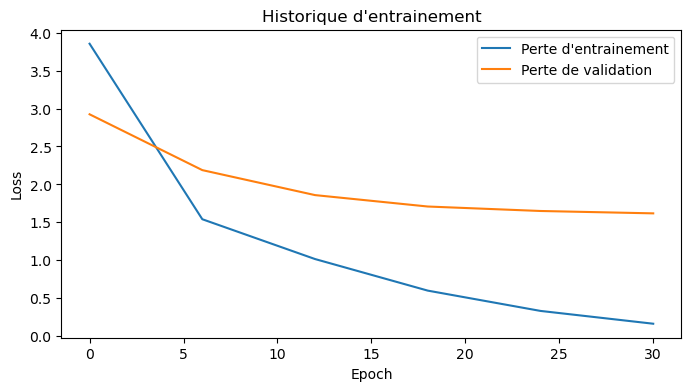

In [50]:
def show_history(history: History):
    """
    Affiche l'historique d'entraînement du modèle dans un graphique

    Args :
        history : Objet contenant les pertes d'entraînement et de
        validation de chaque étape d'entraînement
    """
    # TODO

    plt.figure(figsize=(8,4))
    epochs = np.linspace(0, 30, 6) 
    plt.plot(epochs, history.t_loss[::5], label = 'Perte d\'entrainement')
    plt.plot(epochs, history.v_loss[::5], label = 'Perte de validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Historique d\'entrainement')

    # END TODO

show_history(history)

#### 8.2 Est-ce que le modèle semble être en sur-apprentissage ? Pourquoi ? Que feriez-vous pour résoudre ce problème ? (2 points)

Oui le modèle semble bien être en sur-apprentissage puisque la validation loss augmente pour les derniers epochs.

#### 8.3 Lors de l'entraînement, un modèle a été sauvegardé à chaque 10 époques. En vous basant sur le graphique de la fonction de perte durant l'entraînement, choisissez la sauvegarde du modèle qui n'est pas en sur-apprentissage et chargez le pour l'évaluation à l'aide de la fonction `load` de la classe `Trainer`. Chargez également le dernier modèle sauvegardé pour comparer les résultats. (1 point)

Nous dénoterons le modèle arrêté avant le sur-apprentissage comme étant : `stopped_model`

Nous dénoterons le dernier modèle sauvegardé comme étant : `last_model`

In [51]:
# TODO

# Mettez vos deux modèles entraînés dans ces variables pour la suite
stopped_model = Trainer.load(config=config, path='model_20.pt').to(DEVICE)
last_model = Trainer.load(config=config, path='model_30.pt').to(DEVICE)

# END TODO

C:\Users\mathi\AppData\Local\Temp\ipykernel_62732\1678421726.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


### 9. Évaluation (20 points)

#### 9.1 Génération (10 points)
Maintenant que le modèle est entraîné, nous pouvons tester ses générations. Complétez la fonction `generate` qui génère, pour un lot de données, les prédictions d'un modèle sur les concepts clés de la phrase donnée en paramètre.

In [52]:
def generate(model: Transformer, encoder_in: torch.tensor, bos_token_id: int, eos_token_id: int, max_length=MAX_LENGTH):
    """
    Génère les prédictions d'un modèle pour des phrases données en paramètre. Pour cela, vous devez
    initialiser un tenseur X contenant les jetons de début de phrase (bos_token_id). Ensuite, ce
    tenseur sera passé comme entrée au décodeur avec `encoder_in` comme entrée à l'encodeur. Le modèle
    génèrera un jeton en sortie qui sera le jeton le plus probable étant donné le jeton de début de
    phrase et la séquence passée dans l'encodeur. Ce jeton devra être concaténé au tenseur initial X
    pour former une séquence de deux jetons. Cette nouvelle séquence est ensuite réenvoyée au décodeur.
    Un jeton en sortie sera généré correspondant au jeton le plus probable étant donné la séquence de
    deux jetons et l'entrée de l'encodeur. Le nouveau jeton est concaténé au tenseur X et l'opération
    est répétée jusqu'à ce que le décodeur génère le jeton de fin de phrase.

    Args :
        model : Modèle effectuant les prédictions

        inputs : Tenseur contenant les phrases d'entrées sous forme d'indices de jetons

        bos_token_id : Jeton d'entrée du tokenizer utilisé pour initialiser le tenseur de génération

        eos_token_id : Jeton de fin du tokenizer utilisé pour détecter la fin d'une séquence

        max_length : Nombre maximal de jetons qui doivent être générés par le modèle

    Returns :
    Génération du modèle de chacune des phrases en entrée
    """
    # TODO
    model.eval()

    # Taille du batch courant
    current_batch_size = encoder_in.size(0)

    # Initialisation du tenseur X contenant les jetons de début de phrase (chaque ligne correspondra à la prédiction de "concepts" pour chaque phrase de "sentence" du batch)
    generated_sequences = torch.full((current_batch_size, 1), bos_token_id, dtype=torch.long, device=DEVICE)

    # Initialisation d'un indicateur pour les prédictions terminées
    finished_sequences = torch.zeros(current_batch_size, dtype=torch.bool, device=DEVICE)

    for _ in range(max_length):
        # Appel du modèle pour générer les prédictions pour chaque phrase de "sentence" du batch
        output = model(encoder_in, generated_sequences)
        
        # Récupération des prédictions associées à la dernière séquence de jetons (complète) de decoder_in
        output = output[:, -1, :]

        # Extraction des nouveaux jetons prédits (jetons du vocabulaire dont la probabilité est la plus haute)
        next_tokens = output.argmax(dim=-1, keepdim=True)

        # Concaténation des jetons pour former la nouvelle séquence pour l'appel suivant
        next_tokens[finished_sequences] = eos_token_id # Si un token de fin de phrase a déjà été généré, alors on fixe le token suivant comme un token de fin de phrase.
        generated_sequences = torch.cat([generated_sequences, next_tokens], dim=1)

        # Mise à jour des séquences terminées (si une prédiction a généré un token de fin de phrase, alors la prédiction pour "concepts" est terminée pour cette "sentence")
        finished_sequences = finished_sequences | (next_tokens.squeeze(1) == eos_token_id)
        # On peut s'arrêter si toutes les séquences sont terminées
        if finished_sequences.all():
            break

    return generated_sequences
    # END TODO

In [53]:
def get_predictions(model, tokenizer):

    bos_token_id = tokenizer("")['input_ids'][0]
    eos_token_id = tokenizer("")['input_ids'][1]

    sentences = []
    predictions = []
    ground_truth = []
    for test_data in test_loader:

        inputs = test_data['encoder_in']
        result = generate(model, inputs, bos_token_id, eos_token_id)

        sentences.extend(tokenizer.batch_decode(test_data['encoder_in'], skip_special_tokens=True))
        ground_truth.extend(tokenizer.batch_decode(test_data['decoder_out'], skip_special_tokens=True))
        predictions.extend(tokenizer.batch_decode(result, skip_special_tokens=True))

    return sentences, ground_truth, predictions

sentences_stopped, ground_truth_stopped, predictions_stopped = get_predictions(stopped_model, tokenizer)
sentences_last, ground_truth_last, predictions_last = get_predictions(last_model, tokenizer)

In [54]:
predictions_stopped = pd.DataFrame({'sentences': sentences_stopped, 'ground_truth': ground_truth_stopped, 'predictions': predictions_stopped})
predictions_last = pd.DataFrame({'sentences': sentences_last, 'ground_truth': ground_truth_last, 'predictions': predictions_last})

                                             sentences  \
0    two elephants standing next to each other in t...   
1    A big elephant that is standing there quietly ...   
2                         love the color of this dress   
3                  i just love the colors in her dress   
4            love the colors and print on this dress .   
..                                                 ...   
495         a hiking trail leading off into the forest   
496  trail leading into the forest with moss on bot...   
497                    comedian arrives at awards held   
498                comedian and comedian holds award .   
499                pears growing up a wall in a garden   

                            ground_truth                           predictions  
0     [ ' elephant ' ' pen ' ' stand ' ]  [ ' elephant ' ' stand ' ' stand ' ]  
1     [ ' elephant ' ' pen ' ' stand ' ]  [ ' elephant ' ' stand ' ' stand ' ]  
2       [ ' color ' ' dress ' ' love ' ]       [ ' add ' ' c

In [55]:
predictions_stopped.to_csv('predictions_stopped.csv', index=False)
predictions_last.to_csv('predictions_last.csv', index=False)

#### 9.2 Évaluation naive de la génération (1 point)
Nous allons d'abord mesurer l'efficacité de notre modèle pour extraire les concepts à l'aide d'une métrique de correspondance exacte (exact match). Pour cela, nous allons mesurer le nombre de générations (`predictions`) qui sont identiques à celles qui sont attendues dans l'ensemble de référence (`ground truth`) et diviser le tout par le nombre totaux d'éléments dans l'ensemble de référence. Ainsi, la métrique EM (exact match) équivaut à :

$$\text{EM} = \frac{\text{Nombre d'éléments identiques entre l'ensemble généré et l'ensemble de référence}}{\text{Nombre d'éléments dans l'ensemble de référence}}$$

In [56]:
def compute_em_score(data):
    """
    Évalue la métrique EM du modèle en utilisant la métrique BLEU
    Args :
        - data : DataFrame contenant les colonnes predictions et ground_truth

    Returns :
    La métrique EM du modèle en pourcentage
    """
    # TODO
    
    mean_EM = 0
    for _,row in data.iterrows() :
        EM = 0
        g_t = row['ground_truth'].replace('[', '').replace(']', '').replace("'", "").split()
        preds = row['predictions'].replace('[', '').replace(']', '').replace("'", "").split()
        for pred in preds :
            # Si la prédiction est retrouvée dans la référence
            if  pred in g_t :
                EM+=1
        EM = EM/len(g_t)
        mean_EM += EM 
    mean_EM = mean_EM/len(data)
    return mean_EM     
        
    # END TODO

print(f"La métrique EM du modèle arrêté selon la fonction de perte est {compute_em_score(predictions_stopped):.2f} %")
print(f"La métrique EM du dernier modèle est {compute_em_score(predictions_last):.2f} %")

La métrique EM du modèle arrêté selon la fonction de perte est 0.72 %
La métrique EM du dernier modèle est 0.71 %


#### 9.3 Quels problèmes voyez-vous avec cette manière de calculer la performance du modèle ? (1 point)

On ne prend pas en compte le fait que les mots sont consécutifs.

#### 9.4 Métrique BLEU (4 points)
Pour pallier à ce problème, la métrique BLEU sera utilisée puisqu'elle est basée sur le nombre de n-gramme qui sont présents dans les prédictions et les séquences voulues. La formule est donnée ci-dessous :
$$BLEU = BP * exp \Big( \sum_{n=1}^{N} w_n \log p_n \Big)$$

Considérant que $r$ est la phrase de référence (voulue) et $c$ la phrase générée (candidate), $p_n$ est la précision modifiée pour le n-gramme (correspondant au ratio de la fréquence maximum du n-gramme dans la phrase de référence par la fréquence du n-gramme): 
$$p_n = \frac{\sum_{\text{n-gramme} \in c} \min\Big( \max_{r} \text{Count$_r$(n-gramme)}, \text{Count$_c$(n-gramme)} \Big)}{\sum_{\text{n-gramme} \in c} \text{Count$_c$(n-gramme)}}$$

Notez que le $\max_{r}$ est présent ici car BLEU accepte plusieurs phrases de référence pour une même phrase générée. Cependant, dans notre cas, il y a seulement une seule phrase de référence.

Posons ensuite $|r|$ comme le nombre de mots dans la phrase cible et $|c|$ comme le nombre de mots dans la phrase prédite. Si $c>r$, alors BP vaut 1. Sinon $$BP = exp(1 - \frac{|r|}{|c|})$$

Les valeurs des poids $w_n$ est ce qui donne les différentes variations de la métrique BLEU. Dans notre cas, la métrique BLEU-1 sera utilisée. La valeur maximale du score BLEU est 1 et la valeur minimale est 0.

Vous pouvez utiliser la fonction `sentence_bleu` de `nltk` pour calculer votre score BLEU. N'oubliez pas d'enlever les apostrophes et les crochets des générations avant votre calcul.

In [63]:
from nltk.translate.bleu_score import sentence_bleu
def compute_bleu(predictions):
    """
    Évalue la précision du modèle en utilisant la métrique BLEU
    Args :
        - data : DataFrame contenant les colonnes predictions et ground_truth

    Returns :
        La moyenne du score BLEU
    """
    weights = (1, 0, 0, 0) # Use Bleu-1
    # TODO
     
    bleu_scores = []

    for _, row in predictions.iterrows():
        
        reference = row['ground_truth'].replace('[', '').replace(']', '').replace("'", "").split()
        candidate = row['predictions'].replace('[', '').replace(']', '').replace("'", "").split()

        # Calcul du score BLEU pour une paire de séquence de référence et de séquence prédite
        score = sentence_bleu([reference], candidate, weights=weights)
        bleu_scores.append(score)
    
    mean_bleu = sum(bleu_scores) / len(bleu_scores)
    return mean_bleu
    # END TODO

print(f"Le score BLEU du modèle arrêté selon la fonction de perte est {compute_bleu(predictions_stopped):.2f}")
print(f"Le score BLEU du dernier modèle est {compute_bleu(predictions_last):.2f}.")

Le score BLEU du modèle arrêté selon la fonction de perte est 0.53
Le score BLEU du dernier modèle est 0.61.


#### 9.5 Quel est l'avantage d'utiliser la métrique BLEU par rapport à la métrique EM basée sur la comparaison de chaîne de caractères ? (2 points)

#### 9.6 Que remarquez-vous par rapport aux performances du modèle arrêté avant le sur-apprentissage selon la fonction de perte versus celles du dernier modèle ? Quelles sont les raisons qui peuvent expliquer cela ? (2 points)

### 10. Exploration (4 points)

#### 10.1 Explorez les générations actuelles de votre modèle et ressortez 2 problèmes que le modèle a lors de la génération qui font diminuer son score BLEU. (2 points)

#### 10.2 Amélioration des métriques (2 points)
L'exemple ci-dessous montre 2 générations de 2 modèles pour la phrase "A dog is eating a flower". Bien que la génération du modèle 2 soit beaucoup plus proche sémantiquement de la référence que celle du modèle 1, la métrique BLEU retourne 0.0 dans les deux cas. En effet, puisque la métrique ne compare que les n-grammes, la prédiction du modèle 2 est quand même de 0, car aucun des mots dans la prédiction ne sont présents dans les concepts voulus.

In [60]:
ground_truth = "['dog' 'eat' 'flower']"

prediction_1 = "['car' 'hit' 'person']"
preds = pd.DataFrame({'predictions': [prediction_1], 'ground_truth': [ground_truth]})

print(f"Concepts voulus {ground_truth}")
print(f"Prédiction du modèle 1 : {prediction_1}")
print(f"BLEU : {compute_bleu(preds):.2f}")

prediction_2 = "['animal' 'eating' 'plant']"
preds = pd.DataFrame({'predictions': [prediction_2], 'ground_truth': [ground_truth]})

print(f"Prédiction du modèle 2 : {prediction_2}")
print(f"BLEU : {compute_bleu(preds):.2f}")

Concepts voulus ['dog' 'eat' 'flower']
Prédiction du modèle 1 : ['car' 'hit' 'person']
BLEU : 0.00
Prédiction du modèle 2 : ['animal' 'eating' 'plant']
BLEU : 0.00


Proposez (sans l'implémenter) une meilleure métrique pour évaluer les modèles face à cette tâche d'extraction qui donnerait un score plus élevé à la prédiction du modèle 2. 

## Livrables
Vous devez remettre votre notebook sur Moodle et Gradescope en ipynb et pdf. Pour Gradescope vous devez associer les numéros de questions avec vos réponses dans le pdf grâce à l'outil que fournit Gradescope.


## Évaluation 
Votre TP sera évalué selon les critères suivants :
1. Exécution correcte du code et obtention des sorties attendues
2. Réponses correctes aux questions d'analyse
3. Qualité du code (noms significatifs, structure, performance, gestion d’exception, etc.)
4. Commentaires clairs et informatifs